# Analysis of AF predictions with regard to domain insertions

### Import 

Import packages:

In [ ]:
import sys
sys.path.append('../')
import pickle
import numpy as np
import pandas as pd
import Bio
from Bio import SeqUtils
from Bio.PDB import *
from Bio.PDB import PDBParser
from Bio import pairwise2
import matplotlib.pyplot as plt
import seaborn as sns 
import matplotlib as matplotlib


# set styles
plt.style.use('./utils/domain_ins.mplstyle')

Import data and set dirs

In [ ]:
#general input folder
base = '/camp/lab/debenedictise/home/users/acarb/gitfolder/DI_screen_MathonyDebug'
data_folder = f'{base}/analysis/output_datasets'
fig_folder = f'{base}/analysis/figures'
prot_path = f'{base}/analysis/input_data/hybrid_prediction_screen'

# impoert analysis dict
with open(f'{data_folder}/analysis_dict.pickle', 'rb') as input:
    analysis_dict = pickle.load(input)
input.close()

#import datasets
with open(f'{data_folder}/proteins_training.pickle', 'rb') as input:
    full_dataset = pickle.load(input)
input.close()

protein_combinations = [['AraC', 'PDZ']]


Functions:

In [ ]:
def get_pLDDT(structure):
    '''
    Extracts the pLDDT score for the given structure
    '''
    pLDDT_score = []
    for chain in structure[0]: 
        for residue in chain:
            for atom in residue:
                if atom.full_id[4][0] == 'CA':
                    pLDDT_score.append(atom.bfactor)
    return pLDDT_score


### Process Data

In [ ]:
# Create protein sequence df
import glob # here glob is used to find files with pdb format
positions = pd.Series(glob.glob('./input_data/hybrid_prediction_screen/*.pdb'))
print(positions)
positions = positions.str.split('/', expand=True)[3]
print(positions)
positions = positions.str.split('_', expand=True).iloc[:,:3]
print(positions)

In [ ]:
# Import all the pdb files
parser = PDBParser()
PDBs = {}
for combination in protein_combinations:
    PDBs[f'{combination[0]}_{combination[1]}'] = {}

for idx, pos in positions.iterrows():
    protein = pos[0]
    position = pos[1]
    domain = pos[2]
    PDBs[f'{protein}_{domain}'][f'{protein}_{position}_{domain}'] = {'structure':{}, 'pLDDT':{}, 'RMSD':{}}
    #PDBs[f'{protein}_{domain}'][f'{protein}_{position}_{domain}'] = {'structure':{}, 'pLDDT':{}, 'RMSD':{}}
    PDBs[f'{protein}_{domain}'][f'{protein}_{position}_{domain}']['structure'] = parser.get_structure(position, f'{prot_path}/{protein}_{position}_{domain}_unrelaxed_rank_1_model_3.pdb')
    PDBs[f'{protein}_{domain}'][f'{protein}_{position}_{domain}']['pLDDT'] = get_pLDDT(PDBs[f'{protein}_{domain}'][f'{protein}_{position}_{domain}']['structure'])
    #PDBs[f'{protein}_{domain}'][f'{protein}_{position}_{domain}']['structure'] = parser.get_structure(position, f'{prot_path}/{protein}_{position}_{domain}_unrelaxed_rank_1_model_3.pdb')
    #PDBs[f'{protein}_{domain}'][f'{protein}_{position}_{domain}']['pLDDT'] = get_pLDDT(PDBs[f'{protein}_{domain}'][f'{protein}_{position}_{domain}']['structure'])
#un=get_pLDDT(parser.get_structure('AraC', f'{base}/analysis/input_data/AraC_AF.pdb'))


In [ ]:
print(un)

In [ ]:
#dump the current dataset to pickle
with open(f'{data_folder}/PDBs.pickle', 'wb') as f:
    pickle.dump(PDBs, f) 
f.close() 

In [ ]:
# Import the structures of the WT proteins
parser = PDBParser()
WT_proteins = {}
protein_names = ['AraC', 'PDZ']
for protein in protein_names:
    WT_proteins[protein] = {}
    WT_proteins[protein]['structure'] = parser.get_structure(protein, f'{prot_path}/hybrid_prediction_screen_single_proteins/{protein}_unrelaxed_rank_1_model_3.pdb')

In [ ]:
fusion_seqs = {}
for combination in protein_combinations:
    fusion_seqs[f'{combination[0]}_{combination[1]}'] = {}

#get some data for the structure alignment
for protein in protein_names:
    WT_proteins[protein]['seq'] = ''
    for res in WT_proteins[protein]['structure'].get_residues():
        WT_proteins[protein]['seq'] += SeqUtils.IUPACData.protein_letters_3to1[res.get_resname().title()]

for protein in protein_names:
    WT_proteins[protein]['res'] = []
    for res in WT_proteins[protein]['structure'].get_residues():
        WT_proteins[protein]['res'].append(res['CA'])

for combination in protein_combinations:
    try:
        for idx, AA in enumerate(WT_proteins[combination[0]]['seq']):
            fusion_seqs[f'{combination[0]}_{combination[1]}'][f'{combination[0]}_{AA}{idx+1}_{combination[1]}'] = WT_proteins[combination[0]]['seq'][:idx+1] + WT_proteins[combination[1]]['seq'] + WT_proteins[combination[0]]['seq'][idx+1:]
    except:
        pass

print(WT_proteins)

In [ ]:
RMS = {}
for comb in protein_combinations:
    RMS[f'{comb[0]}_{comb[1]}'] = {}
    RMS[f'{comb[0]}_{comb[1]}'][f'{comb[0]}_rms_values'] = []
    RMS[f'{comb[0]}_{comb[1]}'][f'{comb[1]}_rms_values'] = []

y = 0
for combination, comb_dict in PDBs.items():
        for variant_name, variant in comb_dict.items():
            # align the fusion protein to the parent protein and determine insertion
            alignments = pairwise2.align.globalxs(WT_proteins[combination.split('_')[0]]['seq'], fusion_seqs[combination][variant_name], -1000, -1)
            start = alignments[0][0].find('-')
            end = alignments[0][0].rfind('-')
            insert_alignment = range(start +1, end +2)
            
            #split pLDDT score by parent and insert
            variant['pLDDT_insert'] = variant['pLDDT'][start:end+1]
            variant['pLDDT_parent'] = variant['pLDDT'][:start] + variant['pLDDT'][end+1:]

            # gather the coordinates for the alignment
            candidate_res_ins = []
            candidate_res_par = []
            variant['RMSD_parent'] = []
            variant['RMSD_insert'] = []
            for res in variant['structure'].get_residues():            
                if res.get_id()[1] in insert_alignment:
                    candidate_res_ins.append(res['CA'])
                else: 
                    candidate_res_par.append(res['CA'])

            # perform structure alignment and get rms
            super_imposer = Bio.PDB.Superimposer()
            super_imposer.set_atoms(WT_proteins[combination.split('_')[1]]['res'], candidate_res_ins)
            super_imposer.apply(variant['structure'].get_atoms())
            RMS[f'{combination.split("_")[0]}_{combination.split("_")[1]}'][f'{combination.split("_")[1]}_rms_values'].append(super_imposer.rms)
            for idx, atom in enumerate(candidate_res_ins):
                variant['RMSD_insert'].append(atom - WT_proteins[combination.split('_')[1]]['res'][idx])

            super_imposer.set_atoms(WT_proteins[combination.split('_')[0]]['res'], candidate_res_par)
            super_imposer.apply(variant['structure'].get_atoms())
            RMS[f'{combination.split("_")[0]}_{combination.split("_")[1]}'][f'{combination.split("_")[0]}_rms_values'].append(super_imposer.rms)
            for idx, atom in enumerate(candidate_res_par):
                    variant['RMSD_parent'].append(atom - WT_proteins[combination.split('_')[0]]['res'][idx])

In [ ]:
print(variant['pLDDT_insert'])

### Analysis

In [ ]:
%matplotlib inline
#un=[]
def correlation(x, y, name):
    sns.set_style("ticks")
    data = pd.DataFrame(list(zip(list(x),y)), columns=['enrichment', 'property'])
    data.dropna(inplace=True)
    plt.figure(figsize=(5,5))
    plt.rcParams['axes.linewidth'] = 2
    g = sns.regplot(data=data, x='property', y='enrichment', color='#008080', ci=None, 
        scatter_kws={'alpha':.3, 'linewidth':0}, line_kws={'alpha':1})
    plt.xlabel(name)
    plt.ylabel("Log2 variant enrichment")
    sns.despine()
    plt.title(f"Correlation between enrichment score and {name}")
    plt.show()
    spearman_corr = data.corr(method='spearman').iloc[0, 1]
    print(f"Spearman Correlation between enrichment and {name}: {spearman_corr:.2f}")
# Plot correlations between structures and enrichments
#correlation(full_dataset['AraC']['2']['log'], RMS['AraC_PDZ']['PDZ_rms_values'], 'RMSD PDZ')
#for combination in protein_combinations:
#    for variant_name, variant in PDBs[f'{combination[0]}_{combination[1]}'].items():
#        un.extend(variant['pLDDT_insert'])
#        un.extend(variant['pLDDT_parent'])
#print(un)
#correlation(full_dataset['AraC']['2']['log'], variant['pLDDT_insert'], 'pLLDT PDZ')

correlation(full_dataset['AraC']['2']['log'], full_dataset['AraC']['2']['pLDDT'], 'pLLDT PDZ')

### Merge Data to df and sort by sequence:

In [ ]:
#pack data into dfs
predict_data = {}
for combination in protein_combinations:
    predict_data[f'{combination[0]}_{combination[1]}'] = {}
    predict_data[f'{combination[0]}_{combination[1]}']['pLDDT_parent'] = {}
    predict_data[f'{combination[0]}_{combination[1]}']['pLDDT_insert'] = {}
    predict_data[f'{combination[0]}_{combination[1]}']['RMSD_parent'] = {}
    predict_data[f'{combination[0]}_{combination[1]}']['RMSD_insert'] = {}
    for variant_name, variant in PDBs[f'{combination[0]}_{combination[1]}'].items():
        predict_data[f'{combination[0]}_{combination[1]}']['pLDDT_parent'][variant_name] = variant['pLDDT_parent']
        predict_data[f'{combination[0]}_{combination[1]}']['pLDDT_insert'][variant_name] = variant['pLDDT_insert']
        predict_data[f'{combination[0]}_{combination[1]}']['RMSD_parent'][variant_name] = variant['RMSD_parent']
        predict_data[f'{combination[0]}_{combination[1]}']['RMSD_insert'][variant_name] = variant['RMSD_insert']
    #get residue order
    predict_data[f'{combination[0]}_{combination[1]}'][f'{combination[0]}_AA'] = []
    for position, AA in enumerate(WT_proteins[combination[0]]['seq']):
        predict_data[f'{combination[0]}_{combination[1]}'][f'{combination[0]}_AA'].append(f'{AA}{position + 1}')
    
    #create and process dfs
    for name, dataset in predict_data[f'{combination[0]}_{combination[1]}'].items():
        if name != f'{combination[0]}_AA':
            dataset = pd.DataFrame.from_dict(dataset)
            dataset.columns = dataset.columns.str.replace(f'{combination[0]}_','')
            dataset.columns = dataset.columns.str.replace(f'_{combination[1]}','')
            predict_data[f'{combination[0]}_{combination[1]}'][name] = dataset.reindex(predict_data[f'{combination[0]}_{combination[1]}'][f'{combination[0]}_AA'], axis=1)

pLDDT_parent


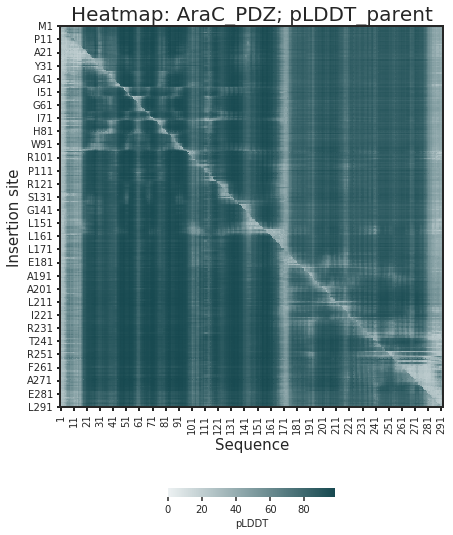

pLDDT_insert


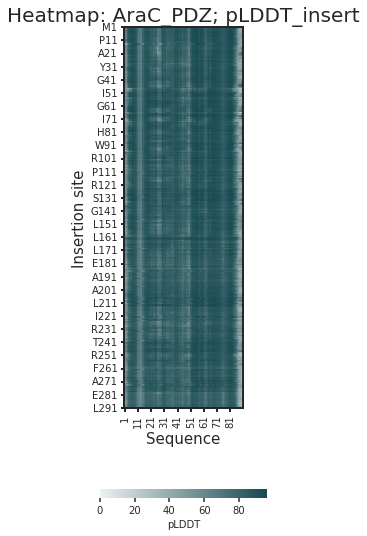

RMSD_parent


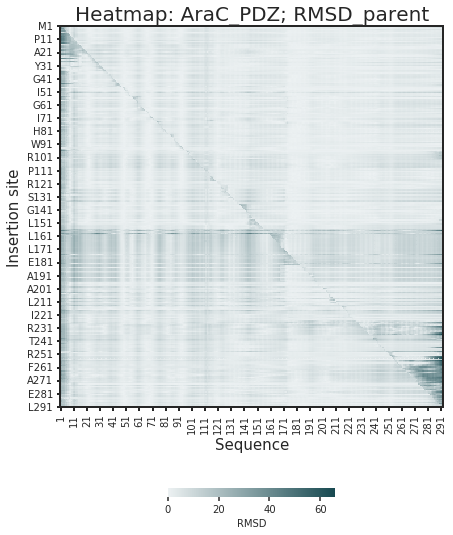

RMSD_insert


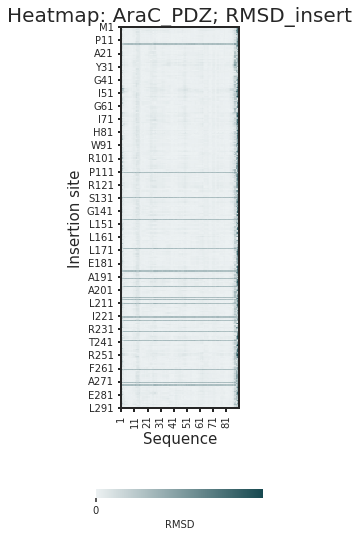

In [123]:
# Plot position-wise correlations
for combination, data_dict in predict_data.items():
    for name, dataset in data_dict.items():
        if name != f'{combination.split("_")[0]}_AA':
            print(name)
            sns.set_style("ticks")
            plt.figure(figsize=(10,10))
            ax =sns.heatmap(data=dataset.T, cmap=sns.light_palette('#174950', as_cmap=True), square=True, robust=False, vmin=0,# vmax=100,
                            cbar_kws={'label': name.split('_')[0], 'shrink':.3, 'orientation':'horizontal', 'ticks': [0, 20, 40, 60, 80, 100], 'extend':'neither'})
            plt.title(f"Heatmap: {combination}; {name}", fontsize=20, y=1.01)
            for _, spine in ax.spines.items():
                spine.set_visible(True)
                spine.set_linewidth(2)
            ax.yaxis.set_tick_params(width=2)
            ax.xaxis.set_tick_params(width=2)
            ax.set_xticks(np.arange(.5, len(dataset.iloc[:,0]) +.5, 10))
            ax.set_xticklabels(np.arange(1, len(dataset.iloc[:,0])+1, 10), fontsize=10)
            ax.set_yticks(np.arange(.5, len(dataset.iloc[0,:]) +.5, 10))
            ax.set_yticklabels(dataset.columns[::10], fontsize=10)
            ax.set_xlabel("Sequence", fontsize = 15)
            ax.set_ylabel("Insertion site", fontsize = 15)
            plt.savefig(f"{fig_folder}/feature_correlation_{combination}_{name}.svg", bbox_inches="tight")
            plt.show()
            plt.close()


In [ ]:
#dump the current dataset to pickle
with open(f'{data_folder}/predict_data.pickle', 'wb') as f:
    pickle.dump(predict_data, f) 
f.close() 

In [125]:
print(predict_data)

{'AraC_PDZ': {'pLDDT_parent':         M1     A2     E3     A4     Q5     N6     D7     P8     L9    L10  \
0    46.69  45.24  30.99  28.51  31.40  28.56  34.22  31.20  32.38  31.89   
1    31.10  40.79  32.54  29.51  32.27  29.09  26.76  33.42  31.58  30.37   
2    35.41  33.97  36.90  28.95  33.71  26.22  25.06  30.12  32.57  27.87   
3    36.94  35.11  38.07  39.31  38.04  34.19  27.68  37.89  35.90  33.34   
4    38.43  36.73  42.75  42.47  48.51  33.50  28.67  38.08  41.74  29.81   
..     ...    ...    ...    ...    ...    ...    ...    ...    ...    ...   
287  43.61  43.63  39.74  42.09  43.07  39.88  41.07  43.36  43.37  40.97   
288  45.45  46.51  42.03  44.45  43.83  41.57  43.31  45.54  45.54  41.22   
289  46.52  46.47  42.56  45.53  44.70  44.50  45.01  45.53  45.87  44.34   
290  43.04  42.66  41.27  42.09  42.11  40.87  41.74  42.28  42.56  41.67   
291  44.81  44.45  42.64  44.22  43.48  42.56  42.52  43.94  43.71  42.17   

     ...   K283   V284   N285   D286   V287  

In [162]:
pd.set_option('display.max_rows', None) 
correlations = {}
for pair, data_dict in predict_data.items():
        for feature, dataset in data_dict.items():
            correlations_list = []
            if isinstance(dataset, pd.DataFrame):
                for position, values in dataset.iterrows():
                    
                    x = pd.Series((analysis_dict[f"AraC_PDZ"]['12']['log'] + analysis_dict[f"AraC_PDZ"]['22']['log'])/2).reset_index(drop=True)
                    #x = pd.Series((full_dataset['AraC']['2']['log'])).reset_index(drop=True)

                    correlations_list.append(values.reset_index(drop=True).corr(x, method='spearman'))
                correlations[f'{pair}_{feature}'] = correlations_list
print(analysis_dict[f"AraC_PDZ"]['12']['log'])

1            NaN
2     -10.000000
3       1.445147
4       1.070752
5       1.543328
6       0.802082
7       0.177214
8      -2.139815
9      -4.078415
10     -2.057353
11    -10.000000
12     -0.217818
13     -2.756487
14     -2.139815
15    -10.000000
16    -10.000000
17     -4.396155
18    -10.000000
19     -4.387743
20    -10.000000
21    -10.000000
22    -10.000000
23    -10.000000
24    -10.000000
25    -10.000000
26    -10.000000
27    -10.000000
28      0.667540
29    -10.000000
30    -10.000000
31     -4.577221
32    -10.000000
33    -10.000000
34    -10.000000
35     -0.576548
36    -10.000000
37     -1.854413
38    -10.000000
39    -10.000000
40    -10.000000
41    -10.000000
42     -2.001109
43     -6.030586
44    -10.000000
45     -3.876781
46     -1.391354
47     -1.947170
48     -2.206930
49    -10.000000
50    -10.000000
51    -10.000000
52     -3.320388
53    -10.000000
54     -2.479665
55    -10.000000
56     -3.073582
57     -1.380174
58      2.996635
59      2.5389

In [ ]:
print(full_dataset)

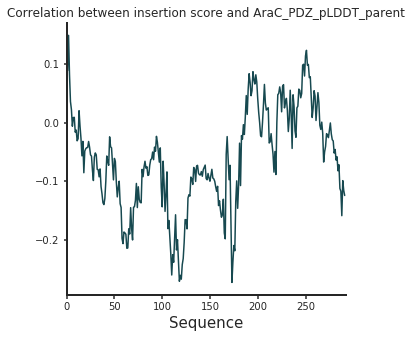

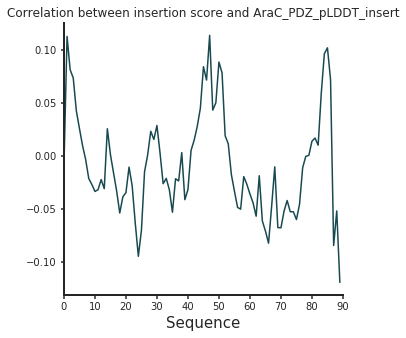

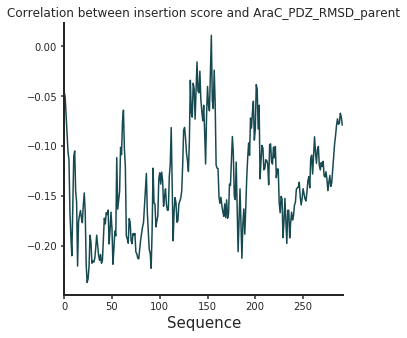

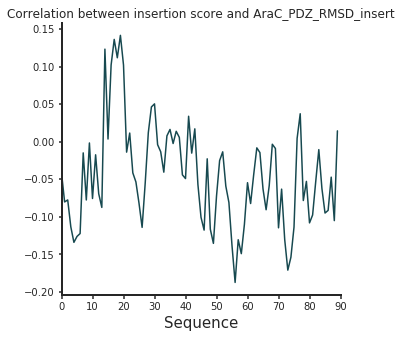

In [154]:
def insertion_line_plot(dataset, title):
    sns.set_style("ticks")
    plt.figure(figsize=(5,5))
    ax =sns.lineplot(data=pd.DataFrame(dataset), legend=False, palette={'#174950'})
    plt.title(title)
    sns.despine()
    ax.set(xlim=(0, len(dataset)))
    ax.set_xlabel("Sequence", fontsize = 15)
    plt.savefig(f"{fig_folder}/feature_correlation_{name}.svg", bbox_inches="tight")
    plt.show()
    plt.close()

for name, dataset in correlations.items():
    insertion_line_plot(dataset, f"Correlation between insertion score and {name}")

In [ ]:
print(x)
x = pd.Series((analysis_dict[f"AraC_PDZ"]['12']['log'] + analysis_dict[f"AraC_PDZ"]['22']['log'])/2)
print(x)